In [1]:
#! -*- coding: utf-8 -*-

## 2. PyCBCチュートリアル：データと信号処理の可視化

重力波データの研究、コンパクトバイナリ合併による天体物理源の発見、それらのパラメータの研究に使用される[PyCBC](http://github.com/ligo-cbc/pycbc) ライブラリを使用します。 これらは、LIGOとVirgoの協力がLIGO / Virgoデータの重力波を見つけるために使用するのと同じツールのいくつかです

このチュートリアルでは、LIGO / Virgoデータを視覚化する方法と、ハイ/ロー・パッシング、PSD推定、ホワイトニングなど、基本的な信号処理を行う方法について説明します。

他の[例](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) とモジュールレベルのドキュメンテーションは[ここ](http://pycbc.org/pycbc/latest/html/py-modindex.html)にあります

#### 生のLIGOデータの表示

以下では、生のLigoデータを表示します。 大きな低音の内容（大きなオシレーションで示される）があり、データにはDCオフセットさえあります。

In [2]:
%matplotlib inline

# Read in the data around GW150914
from pycbc.catalog import Merger
import pylab

m = Merger('GW150914')

data = {}
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

##### GW150914の32秒間のデータ全体

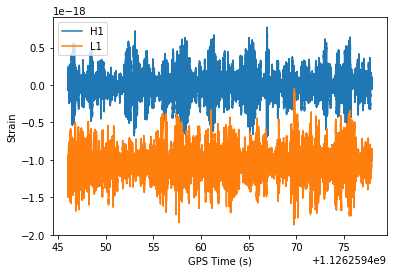

In [3]:
for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo)

pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()

##### GW150914付近1秒間のズーム

GW150914の周りを1秒にズームするだけで、高い周波数のノイズ（および信号）よりもはるかに大きいので、低周波ノイズの振る舞いがわかります。

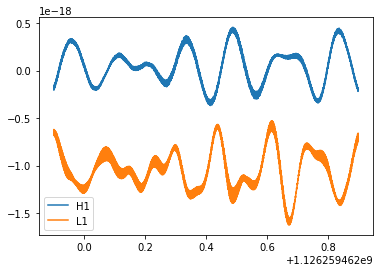

In [4]:
for ifo in data:
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = data[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

#### データをハイパスして低周波成分を取り除く

以下では、ハイパスフィルタをデータに適用して、検出器の低周波ノイズを抑制します。 これにより、データのダイナミックレンジがほぼ同じ範囲に収まることがわかります。 しかし、明らかに依然としていくつかの優勢なノイズが存在する。 これを抑えるには、ホワイトニングフィルタを適用する必要があります。

#### ['clang', '-fno-strict-aliasing', '-I/anaconda/envs/py2/include', '-mmacosx-version-min=10.9', '-m64', '-fPIC', '-DNDEBUG', '-g', '-fwrapv', '-O3', '-Wall', '-Wstrict-prototypes'] #######


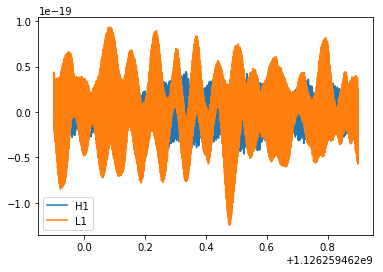

In [5]:
for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    # Options
    # 1) highpass frequency
    # 2) half sample length of highpass filter 
    #(higher value will give less ripple in passband)
    high_data = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

#### データのパワースペクトル密度（PSD）はどのくらいですか？

LIGOのデータ解析では、ノイズパワーが周波数にどのように変化するかを理解することが重要です。 この
セクションでは、[Welchの方法](https://en.wikipedia.org/wiki/Welch%27s_method)のバージョンを使用しています。
データのパワースペクトル密度を推定する。

低周波（桁違いのオーダー）にはかなりの量のノイズが存在することに注意してください。 また、いくつかの特定の周波数では大きなパワーがあることにも注意してください。 これらの原因には、60Hzの電源ラインノイズ、ハンギングミラーのバイオリンモード、およびその他の様々な機器の共鳴が含まれます。 2KHzより低い周波数のパワーの低下は、データを4096Hzに再サンプリングする前にローパスフィルタが適用されたためです。

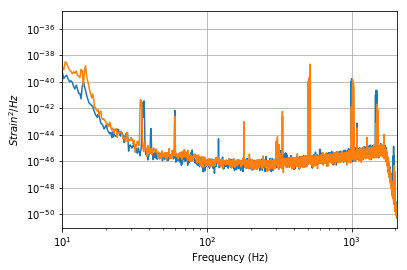

In [6]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.show()

#### データを白くする

ノイズとの差を視覚化するには、ある周波数範囲内のデータを「白くする」ことが有用です。 このようにして、データはゼロからの差として見える。 ホワイトニングはデータを取り込み、すべての周波数が等しく寄与するようにパワースペクトル密度をフラットにしようとします。

以下では、データを白色化し、特定の周波数範囲に焦点を当てて結果をバンドパスします。

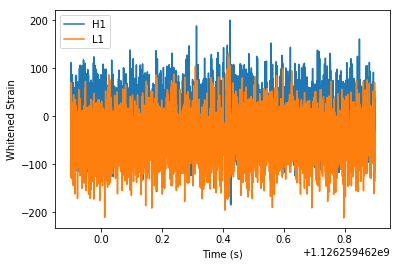

In [7]:
# Whiten the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

GW150914のデータを30〜250Hzの間でバンドパスします。 これにより、この種の信号に寄与しない周波数範囲が除去され、問題の信号を見ることが可能になります。

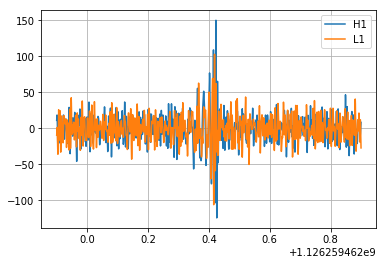

In [8]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

#### プロットをGW150914の周りにフォーカスする

上記のプロットでは、ノイズの上に信号があることがわかります。 今度はこの時間をズームし、2つの時系列を整列させましょう。

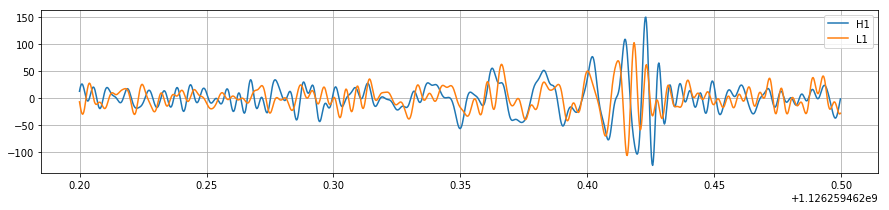

In [9]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

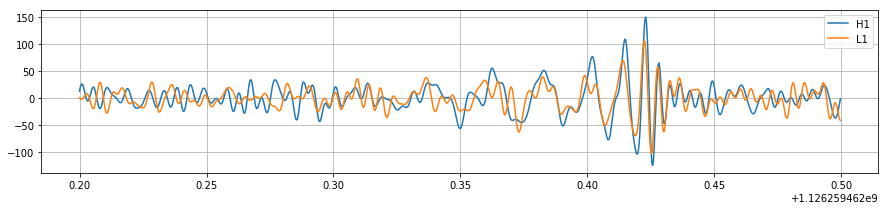

In [10]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - 0.2, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

数サイクルの位相で一致するコヒーレントな信号があることがわかります。この信号は、上のプロットの約0.44で終わります。

#### Q変換プロットでデータを可視化する

重力波データを視覚化する一般的な方法は、[定常-Q変換](https://en.wikipedia.org/wiki/Constant-Q_transform)　として知られている時間 - 周波数表現です。 これは短時間のフーリエ変換で作られた標準的なスペクトログラムに似ていますが、周波数ビンが高周波数でより疎であるという利点があります。

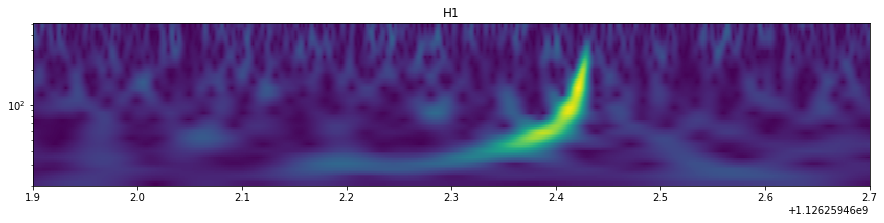

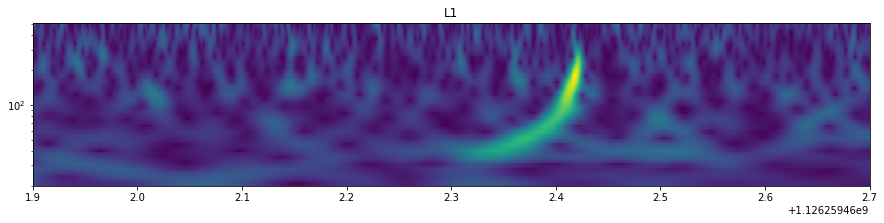

In [11]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()

GW150914信号はq変換出力では比較的明確です。そのためQ変換は強力な武器になります。 しかし、静かな信号、特にGW150914よりも質量が小さい信号は、視覚的に見つけるのが難しいでしょう。 実際には、データ内の信号を見つけるために[マッチトフィルタリング](https://en.wikipedia.org/wiki/Matched_filter)という手法を使用しています。

## チャレンジ！

上記の方法を使用して、これらのデータセットでチャープ（歌う）信号を視覚的に検出できるかどうかを確認します。 どれにシグナルが入っていますか？ ガウスノイズだけが含まれていますか？

役に立つ情報：

* 信号はすべてフレームファイルに100秒から120秒の間に置かれます。
* データを白くしてから、qtransformをプロットしてみてください。
* 各ファイルは、gps時間0で開始し、gps時間128で終了します。
* 各ファイルのチャンネル名は "H1：TEST-STRAIN"です。

In [12]:
# Download the challenge set files
import urllib

def get_file(fname):
    url = "https://github.com/ahnitz/odw-storage/raw/master/{}"
    url = url.format(fname)
    urllib.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf',
         'PyCBC_T2_3.gwf', 'PyCBC_T2_4.gwf']

for fname in files:
    get_file(fname)

Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_0.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_1.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_2.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_3.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_4.gwf


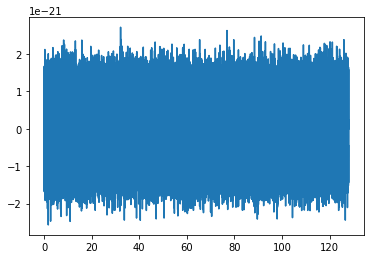

In [13]:
import pycbc.frame

# example of reading the strain in (note this is the same as in PyCBC tutorial 1)
ts = pycbc.frame.read_frame('PyCBC_T2_0.gwf', 'H1:TEST-STRAIN', 0, 128)
pylab.plot(ts.sample_times, ts)
pylab.show()

In [14]:
pycbc.__version__
ts = pycbc.frame.query_and_read_frame('H1_LDAS_C02_L2', 'H1:LDAS-STRAIN',968995968, 968995968+2048)

ValueError: Trying to obtain the ligo datafind server url from the environment, ${LIGO_DATAFIND_SERVER}, but that variable is not populated.

In [19]:
pycbc.__version__

'1.12.2'

In [14]:
import os
os.environ["LIGO_DATAFIND_SERVER"] = "ldr.ligo.caltech.edu"